# Pruebas

+ En las definiciones de las funciones en LennardGas ya no se suponen valores predeterminados para los parámetros, siempre hay que darlos explicitamente para realizar pruebas.

In [1]:
using PyCall, PyPlot, Distributions
@pyimport matplotlib.animation as anim

In [2]:
push!(LOAD_PATH, pwd())
using LennardGas

In [3]:
#Parámetros
r_c = 2.5
L   = r_c * 100
cajitas = 2^60
h = 0.005;

In [4]:
particulas = 50;

#### Condición inicial gaussiana

In [5]:
#Condición inicial (en Float64)
inicial = rand(Normal(L/2, 5.0), 3*particulas)
segundo = fluctuacion_gaussiana(inicial, 0.0, 0.5);

In [6]:
#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas);

In [7]:
@time vector_fuerzas(X0 , L, cajitas, r_c, h);

  0.556904 seconds (2.11 M allocations: 134.109 MB, 24.00% gc time)


In [8]:
@time X2 = paso_verlet(X0, X1, L, cajitas, r_c, h);

  0.575721 seconds (2.01 M allocations: 129.970 MB, 28.73% gc time)


In [9]:
#Reversibilidad tras un paso
X_0 = paso_verlet(X2, X1, L, cajitas, r_c, h);
X0 == X_0

true

In [10]:
#Compilación de evolución
pasos = 5
@time registro = evolucion(X0, X1, pasos, L, cajitas, r_c, h);

  2.458156 seconds (10.09 M allocations: 652.905 MB, 27.25% gc time)


### Prueba de reversibilidad

In [11]:
function prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h) 
    #Se puede hacer sin guardar todos los intermediarios...
    
    registro_ida = evolucion(X0, X1, pasos, L, cajitas, r_c, h)
    X_ultima = collect(registro_ida[end,:])
    X_penultima = collect(registro_ida[end-1,:])

    registro_vuelta = evolucion(X_ultima, X_penultima, pasos, L, cajitas, r_c, h)
    X_original = collect(registro_vuelta[end,:])

    println(X0 == X_original)
    registro_ida, registro_vuelta
end

prueba_reversible (generic function with 1 method)

## Graficando

In [12]:
function organizador(registro::Matrix{Int64}, tiempo::Int64)
    
    N = size(registro, 2)÷3 #Funciona si el número de entradas es múltiplo de 3
    coord = registro[tiempo, :]
    x = zeros(N)
    y = zeros(N)
    z = zeros(N)
    for i in 1:N
        x[i] = coord[3i-2]
        y[i] = coord[3i-1]
        z[i] = coord[3i]
    end
    x,y,z
end
    #plot3D(x, y, z, "b.", markersize = 4.0)

organizador (generic function with 1 method)

In [44]:
function fotograma(registro::Matrix{Int64}, tiempo::Int64; cajitas::Int64 = 0)
    
    if (tiempo < 0) | (tiempo > size(registro, 1))
        return println("El tiempo solicitado no se encuentra disponible en el registro dado.")
    end
    
    x,y,z = organizador(registro, tiempo)    
    plot3D(x, y, z, "b.", markersize = 4.0)
    #axis("off")
    
    #Si se especifica cajitas se evita el "zoom" automático.
    if cajitas != 0
        xlim(1,cajitas)
        ylim(1,cajitas)
        zlim(1,cajitas)
    end
end

fotograma (generic function with 1 method)

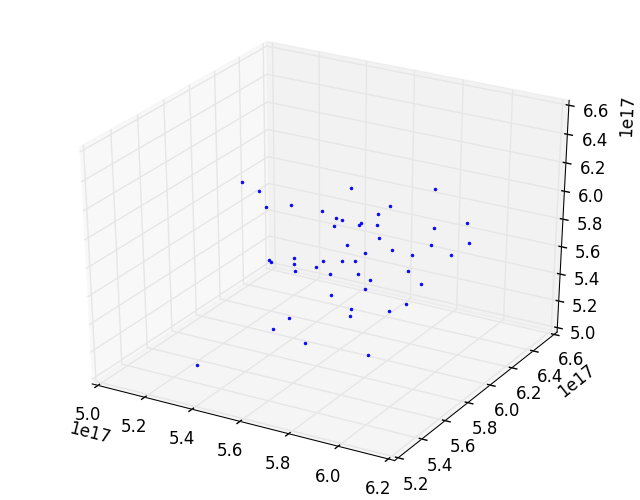

In [14]:
fotograma(registro, 1, cajitas = 2^60)

In [15]:
typeof(ans)

Void

### Distribución inicial cúbica

In [51]:
pasos = 50

raiz_cub_part = 13
@show particulas = raiz_cub_part^3

#Condicion inicial (en Float64)
inicial = cubito(raiz_cub_part, [L/2,L/2,L/2], L/4)
segundo = fluctuacion_gaussiana(inicial, 0.0, 1.0)

#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas)
@time registro = evolucion(X0, X1, pasos, L, cajitas, r_c, h);

particulas = raiz_cub_part ^ 3 = 2197
 90.729253 seconds (403.71 M allocations: 25.558 GB, 28.62% gc time)


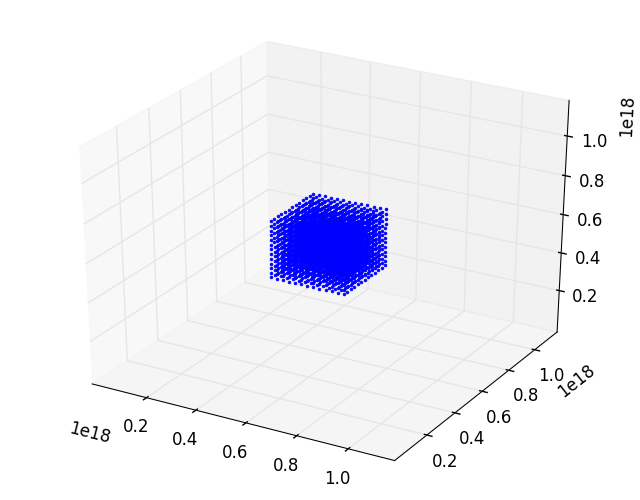

(1,1152921504606846976)

In [52]:
temp_inicial = 1
fotograma(registro, temp_inicial; cajitas = 2^60)

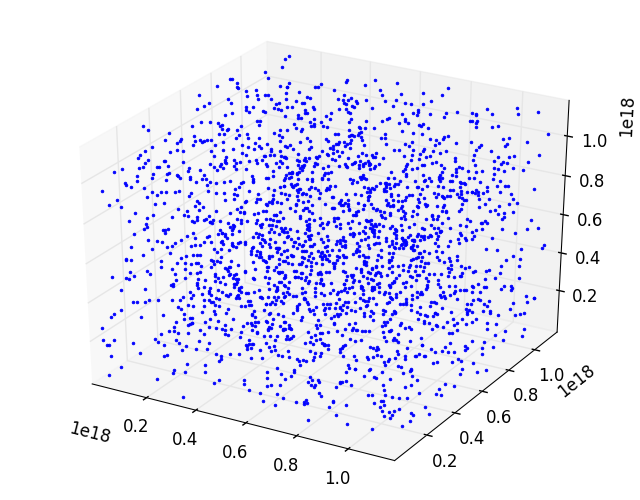

(1,1152921504606846976)

In [53]:
temp_final = size(registro, 1)
fotograma(registro, temp_final; cajitas = 2^60)

**Ejemplo:** https://github.com/JuliaLang/IJulia.jl/issues/107

#### Por alguna extrañisima razon utilizar fotografo! no funciona.

#### Esto sí funciona, es casi lo mismo que fotografo.

470.407294 seconds (36.89 k allocations: 21.904 MB, 0.00% gc time)


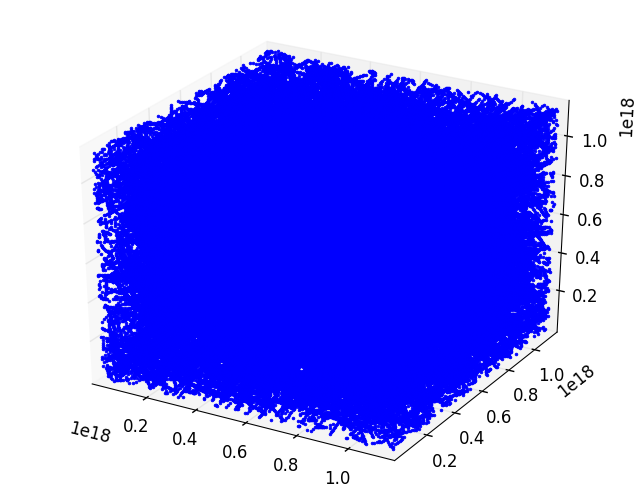

(1,1152921504606846976)

In [54]:
paso_temp = size(registro, 1)
fig = figure()
rollo = []
@time for t in 1:paso_temp
    #fg = fotograma(registro, t)
    x,y,z = organizador(registro,t)
    fg = plot3D(x, y, z, "b.", markersize = 4.0)
    push!(rollo, collect(fg))
end

xlim(1,cajitas)
ylim(1,cajitas)
zlim(1,cajitas)

In [55]:
typeof(rollo)

Array{Any,1}

In [56]:
@time ani = anim.ArtistAnimation(fig, rollo, interval = 100, blit = true, repeat = true, repeat_delay = 2000)
ani[:save]("ani.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"]);

  0.462413 seconds (703 allocations: 13.188 KB)


_Todo en una función_

In [62]:
function animador(registro, nombre::ASCIIString)
    
    fig = figure()
    rollo = []
    
    paso_temp = size(registro, 1)
    for t in 1:paso_temp
        x,y,z = organizador(registro,t)
        fg = plot3D(x, y, z, "b.", markersize = 4.0)
        push!(rollo, collect(fg))
    end

    #axis("off")
    xlim(1,cajitas)
    ylim(1,cajitas)
    zlim(1,cajitas)    
    
    ani = anim.ArtistAnimation(fig, rollo, interval = 100, blit = true, repeat = true, repeat_delay = 2000)
    ani[:save](nombre*".mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

animador (generic function with 1 method)

### Animando la ida y la vuelta

In [59]:
pasos = 50

raiz_cub_part = 13
@show particulas = raiz_cub_part^3

#Condicion inicial (en Float64)
inicial = cubito(raiz_cub_part, [L/2,L/2,L/2], L/4)
segundo = fluctuacion_gaussiana(inicial, 0.0, 1.0)

#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas)
@time registro_ida, registro_vuelta = prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h);

particulas = raiz_cub_part ^ 3 = 2197
true
 51.335904 seconds (202.10 M allocations: 12.781 GB, 28.03% gc time)


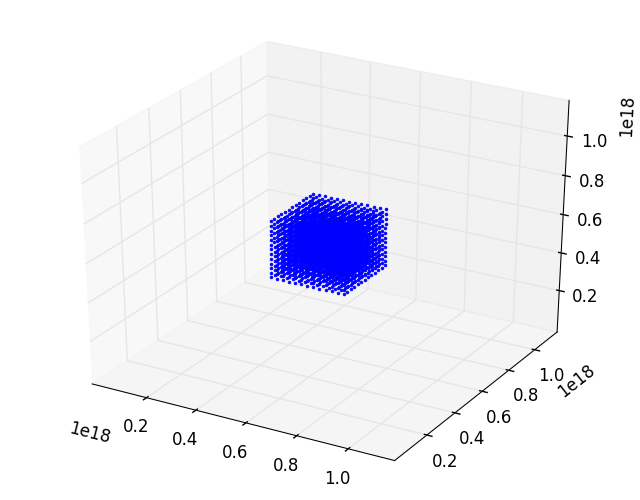

In [63]:
registro_maestro = vcat(registro_ida, registro_vuelta)
animador(registro_maestro, "ida_y_vuelta")

**Proyecto gravitacion Capitán Sanders**

Basado en: https://github.com/dpsanders/fisica_computacional/blob/master/como_animar.ipynb